In [18]:
import pandas as pd

import numpy as np
import numpy.linalg as lin
from numpy.linalg import LinAlgError
from itertools import combinations_with_replacement, combinations
from functools import reduce
import matplotlib.pyplot as plt

# 모델: Polynomial Features

In [19]:
class PolynomialFeatures:
    '''
    다항식으로 feature space 변환
    쓰여진 모듈
    1> itertools.combinations_with_replacement, combinations
    2> numpy
    '''
    __slots__ = ['degree', 'interaction_only', 'self_only']
    def __init__(self, degree = 2, interaction_only = False, self_only = False):
        self.degree = degree
        self.interaction_only = interaction_only
        self.self_only = self_only
        
        if (self.self_only == True) and (self.interaction_only == True):
            raise Exception("either self_only or interaction_only can be True")
        
        if self.degree > 8: 
            raise Exception("Too high degree!!")
            
    def fit_transform(self, X):
        #1. 열 별로 추출
        col_list = [col for col in X.T]
        
        #2. 열 별로 deg에 맞춰 새로운 X를 생성한다.
        feature_spaces = None
        
        for deg in range(1,self.degree+1): #self.degree까지 포함되어야 한다.
            if deg == 1:
                feature_spaces = self.__combination(col_list, deg)
            else:
                feature_spaces = np.vstack( (feature_spaces, self.__combination(col_list, deg)) ) 
                
        return feature_spaces.T
    
    def __combination(self, col_list, n): #deg n 의 조합들 생성
        
        combination_cols = None
        feature_space_degree_n = None
        
        if self.interaction_only == True:
            combination_cols = combinations(col_list, n)
        
        elif self.self_only == True:
            combination_cols = map(lambda col: [col]*n, col_list)
        
        else:
            combination_cols = combinations_with_replacement(col_list, n)
        
        
        for idx, combination in enumerate(combination_cols):
            current = reduce(lambda x,y: x*y, combination)
        
            if idx == 0:
                feature_space_degree_n = current
            else :
                feature_space_degree_n = np.vstack((feature_space_degree_n, current))        
        return feature_space_degree_n #return = ndarray type

# KNN Regression

In [20]:
class KNNRegressor:
    __slots__ = ['n','normalize','copy_train','distance','gamma','degree','theta','train_std','train_mean']
    def __init__(self, n=2, normalize = True, copy_train = True, distance = 'linear', gamma = 1, degree = 3, theta = 0):
        self.n = n
        self.copy_train = copy_train
        self.normalize = normalize
        self.distance = kernel
        self.gamma = gamma
        self.degree = degree
        self.theta = theta
    '''-----------------------------------------------------------------------------------------------'''
    
    def fit(self, X, y):
        if self.copy_train == True:
            self.train_X = np.copy(X)
            self.train_y = np.copy(y)
        else:
            self.train_X = X
            self.train_y = y
        
        if self.normalize == True:
            self.train_mean = self.train_X.mean()
            self.train_std = self.train_X.std()
            self.train_X = self.__normalize(self.train_X)
            
    '''-----------------------------------------------------------------------------------------------'''
    #distance = origin으로부터의 거리! = sqrt(K(x,x))로 정의할 수 있다.
    def predict(self, X_pred):        
        if self.normalize == True:
            X_pred = self.__normalize(X_pred)
        
        distance = self.__distance()
        
        '''-----------------------------------------------------------------------------------------------'''
        
        neighbors = list(zip(map(distance,self.train_X), self.train_y)) #list(map(distance, self.train_X))  
        
        #selection sort를 1~n까지만
        for i in range(self.n):
            min = i
            for j in range(len(neighbors)):
                if neighbors[i][0] > neighbors[j][0] : 
                    min = j
            tmp = neighbors[i]
            neighbors[i] = neighbors[min]
            neighbors[min] = tmp
        
        neighbors = neighbors[:self.n]
        distance = [d for d,_ in neighbors]
        label = [l for _,l in neighbors]
        
        '''-----------------------------------------------------------------------------------------------'''
        
        if self.n == 1:
            return label[0] 
        else:
            prop = 1 - np.array(distance)/np.sum(distance)  #1 - dist/np.sum(dist) #weighted average를 위해
            predict_label = prop.dot(label)
        
            return predict_label
        
    '''-----------------------------------------------------------------------------------------------'''
    def __distance():
        if self.distance == 'l2_norm' :
            if type(X_pred) != np.ndarray:
                return lambda y: (X_pred-y)**2
            else:
                return lambda y : (X_pred-y).dot(X_pred-y)
        
        elif self.distance == 'l1_norm':
            return lambda y : np.sum(np.abs(X_pred-y))
            
        elif self.distance == 'sigmoid':
            if type(X_pred) != np.ndarray:
                return lambda y : np.tanh(self.gamma*((y-X_pred)*(y-X_pred)) + self.theta)
            else:
                return lambda y: np.tanh(self.gamma*((y-X_pred).dot((y-X_pred))) + self.theta)
        
        elif self.distance == 'poly' :
            if type(X_pred) != np.ndarray:
                return lambda y :(self.gamma*((X_pred-y)**2)+self.theta)**self.degree
            else:
                return lambda y: (self.gamma*((X_pred-y).dot(X_pred-y))+self.theta)**self.degree
        
    '''-----------------------------------------------------------------------------------------------'''
    
    def score(self, X, y):
        y_pred = np.array([self.predict(data) for data in X])
        
        return self.__r2_score(y,y_pred)
    '''-----------------------------------------------------------------------------------------------'''
    
    def __r2_score(self, y_true, y_pred):
        SS_total = 0
        SS_reg = 0
    
        for i in range(len(y_true)):
            x = (y_true[i] - y_pred[i])**2
            SS_reg = SS_reg+x
    
        y_true_mean = np.mean(y_true)
        for i in range(len(y_true)):
            x = (y_true[i]-y_true_mean)**2
            SS_total = SS_total+x
        return 1 - (SS_reg/SS_total)
    '''-----------------------------------------------------------------------------------------------'''
    
    def __normalize(self, data):
        data = (data - self.train_mean)/self.train_std
        return data
    '''-----------------------------------------------------------------------------------------------'''

# Linear Regression Model

In [21]:
from abc import *
class base_linear_model(ABC):
    __slots__ = ['alpha', 'copy_X', 'normalize', 'max_iter','train_mean','train_std','weight']
    def __init__(self, alpha = 0.01, copy_X = True, normalize = True, fit_intercept = True, max_iter = None):
        self.alpha = alpha
        self.copy_X = copy_X
        self.normalize = normalize
        self.max_iter = max_iter
        self.train_mean = None
        self.train_std = None
        
    @abstractmethod
    def fit(self,X,y):
        pass
    @abstractmethod
    def predict(self, X):
        pass
    @abstractmethod
    def score(self, X,y):
        pass        
    
    @abstractmethod
    def gradient(self, X,y,w):
        pass
    
    def gradient_descent(self, X,y):
        #heavy ball method
        #1. 초기값 정하기
        tolerence = 1.0e-6
        gravities = np.logspace(-4,0,5) #중력
        steps = np.logspace(-5,1,7) #이동 거리
        prv_weight = np.copy(self.weight) #중력 방향
        
        
        for _ in range(self.max_iter):
            gradient = self.gradient(X,y, self.weight)
            direction = (-1) * (gradient/np.sqrt(gradient.dot(gradient)))
            
            #2. 종료조건 탐색 ==> 기울기가 0에 수렴하는가.
            if gradient.dot(gradient) < tolerence:
                return self.weight
            
            #3. 다음 위치 찾기
            next_weights = [(self.weight + step*direction + gravity*(self.weight - prv_weight)) for step in steps for gravity in gravities]
            
            next_gradients = [self.gradient(X,y,w) for w in next_weights]
            
            next_gradients = [g.dot(g) for g in next_gradients]
            
            min_idx = np.argmin(next_gradients)
            
            #4.update
            prv_weight = np.copy(self.weight) #중력 방향
            self.weight = next_weights[min_idx]
        
        return self.weight
    
    
    def normalize_(self, data):
        data = (data - self.train_mean)/self.train_std
        return data
    
    def r2_score(self, y_true, y_pred):
        SS_total = 0
        SS_reg = 0
    
        for i in range(len(y_true)):
            x = (y_true[i] - y_pred[i])**2
            SS_reg = SS_reg+x
    
        y_true_mean = np.mean(y_true)
        for i in range(len(y_true)):
            x = (y_true[i]-y_true_mean)**2
            SS_total = SS_total+x
        return 1 - (SS_reg/SS_total)
    
    
    def predict(self, X):
        if self.normalize == True:
            X = self.normalize_(X)
        
        X = self.include_bias(X)
        
        return np.dot(X,self.weight)
     
    def score(self, X, y_true):
        y_pred = self.predict(X)
        return self.r2_score(y_true, y_pred)
    
    def include_bias(self, data):
        try:
            if len(data) < 2:
                data = np.hstack((data,1))
            else:
                data = np.hstack((data,np.ones((data.shape[0],1))))
        except:
            print("Only ndarray accept!!")
        
        return data

# Linear-1: Ridge

In [22]:
class Ridge(base_linear_model):
    __slots__ = ['alpha', 'copy_X', 'normalize', 'max_iter','train_mean','train_std','weight','X_train']
    
    def __init__(self, alpha = 0.01, copy_X = True, normalize = True, max_iter = 1000):
        super().__init__(alpha = alpha, copy_X = copy_X, normalize = normalize, max_iter = max_iter)
    
    
    def fit(self, X, y):
        self.weight = None
        
        if self.copy_X == True:
            self.X_train = np.copy(X)
        else:
            self.X_train = X
        
        if self.normalize == True:
            self.train_mean = self.X_train.mean()
            self.train_std = self.X_train.std()
            
            self.X_train = super().normalize_(self.X_train)
        
        self.X_train = super().include_bias(self.X_train)
        
            
        try :
            XT = self.X_train.T
            step1 = lin.inv(XT@self.X_train + self.alpha*(np.eye(XT.shape[0])))
            self.weight = step1@XT@y
            
        except LinAlgError as e: #inv를 구할 수 없다. ==> 경사하강법 사용
            
            self.weight = np.random.randn(self.X_train.shape[1]) #weight initialize
            self.weight = self.gradient_descent(self.X_train,y) #경사하강법으로 찾는다.
        
        return self
    
    def gradient(self, X, y, w):
        OLS_gradient = -2*X.T@(y-X.dot(w))
        Ridge_term = 2*self.alpha*w
        return OLS_gradient + Ridge_term    

# Linear-2 : Lasso

In [23]:
class Lasso(base_linear_model):
    __slots__ = ['alpha', 'copy_X', 'normalize', 'max_iter','train_mean','train_std','weight','X_train']
    def __init__(self, alpha = 0.01, copy_X = True, normalize = False, max_iter = 1000):
        super().__init__(alpha = alpha, copy_X = copy_X, normalize = normalize, max_iter = max_iter)

        
    def fit(self, X,y):
        
        if self.copy_X == True:
            self.X_train = np.copy(X)
        else:
            self.X_train = X
        
        if self.normalize == True:
            self.train_mean = self.X_train.mean()
            self.train_std = self.X_train.std()
            self.X_train = super().normalize_(self.X_train)
        
        self.X_train= super().include_bias(self.X_train)
        
        #gradient Descent 이용
        self.weight = np.random.randn(self.X_train.shape[1])
        self.weight = self.gradient_descent(self.X_train, y)

                
        return self
    
    
    def gradient(self, X,y,w):
        #partial gradient를 구한 후, 하나로 합친다.
        m,n = X.shape #m: data 수, n: feature 수
        
        gradient = np.zeros(w.shape)

        gradient = -2*X.transpose().dot((y-X.dot(w))) #RSS Term
        
        for j in range(n):
            if w[j] > 1.0e-4:
                gradient[j] += self.alpha
            elif w[j]<-1.0e-4:
                gradient[j] -= self.alpha
            else:
                gradient[j] += 0 #subderivative
        
        return gradient

# Linear-3 : Elastic Net

In [24]:
class ElasticNet(base_linear_model):
    __slots__ = ['alpha', 'copy_X', 'normalize', 'max_iter','train_mean','train_std','weight', 'L1_ratio','X_train']
    def __init__(self, alpha = 1, L1_ratio = 0.3, normalize =True, copy_X = True, max_iter = 1000):
        super().__init__(alpha = alpha, copy_X = copy_X, normalize = normalize, max_iter = max_iter)
        self.L1_ratio = L1_ratio

    def fit(self, X, y):
        if self.copy_X == True:
            self.X_train = np.copy(X)
  
        if self.normalize == True:
            self.train_mean = self.X_train.mean()
            self.train_std = self.X_train.std()
            self.X_train = super().normalize_(self.X_train)
              
        self.X_train = super().include_bias(self.X_train)
        
        
        self.weight = np.random.randn(self.X_train.shape[1])
        self.weight = super().gradient_descent(self.X_train, y)
                
        return self
    
    def gradient(self, X,y,w):
        OLS_gradient = -2*X.T.dot(y-X.dot(w))
        Ridge_gradient = self.alpha*(1-self.L1_ratio)*2*w
        
        Lasso_const = self.alpha*self.L1_ratio
        Lasso_gradient = np.zeros(w.shape)
        for i in range(len(w)):
            if w[i] > 1.0e-4:
                Lasso_gradient[i] = Lasso_const*1
            elif w[i] < -1.0e-4:
                Lasso_gradient[i] = Lasso_const*(-1)
            else:
                Lasso_gradient[i] = 0

        return OLS_gradient + 0.5*(Ridge_gradient + Lasso_gradient)

# Test

1. Data 불러오기

In [25]:
train_data = pd.read_csv('~/ml/data/test3_data/test3_data_train.csv')
test_data = pd.read_csv('~/ml/data/test3_data/test3_data_test.csv')

'''-----------------------------------------------------------------------------------------------'''

target = ['prop_log_historical_price']

train_data_price = train_data.drop(target, axis = 'columns').values
train_target_price = train_data[target[0]].values

'''-----------------------------------------------------------------------------------------------'''

test_data_price = test_data.drop(target, axis = 'columns').values
test_target_price = test_data[target[0]].values

'''-----------------------------------------------------------------------------------------------'''
#Polynomial Features를 적용하기

#train_data_price = poly.fit_transform(train_data_price)
#test_data_price = poly.fit_transform(test_data_price)

'-----------------------------------------------------------------------------------------------'

2. Model 불러오기

In [26]:
model = Ridge()
model.fit(train_data_price, train_target_price)

3. 예측하기

In [29]:
print(model.score(test_data_price, test_target_price))

0.6774405687574274


4. weight 양상 저장하기

FileNotFoundError: [Errno 2] No such file or directory: '/ml/Picture/result.png'

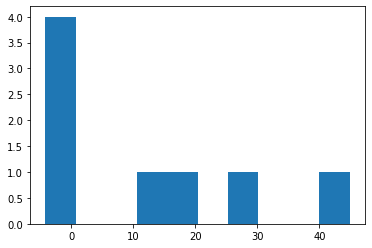

In [32]:
path = r'/ml/Picture/result.png'
plt.hist(model.weight[:len(model.weight)-1]) #X = [X , 1]으로 bias를 포함하고 있다. 따라서, 마지막 weight는 모델의 복잡도에 관여하지 않으므로, 제외한다.
plt.savefig(path)